In [ ]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils import data
import torch.nn.functional as F
from torch.autograd import Variable

import PIL
from PIL import Image
import random 
import numpy as np

import os
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [ ]:
project_name = "emotion-detection-triple"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('./drive/MyDrive/machine learning datasets/archive.zip', 'r') as zip_ref:
    zip_ref.extractall(path='./data')

In [ ]:
data_dir = './data'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['surprise', 'happy', 'sad', 'angry', 'fear', 'neutral', 'disgust']


In [ ]:
happy_files = os.listdir(data_dir + '/train/happy')
sad_files = os.listdir(data_dir + '/train/sad')
angry_files = os.listdir(data_dir + '/train/angry')
print(happy_files[:5])
print("Number of images with happy faces: ",len(happy_files))
print("Number of images with sad faces: ",len(sad_files))
print("Number of images with angry faces: ",len(angry_files))

['Training_69853347.jpg', 'Training_85027104.jpg', 'Training_18578886.jpg', 'Training_83775808.jpg', 'Training_65414485.jpg']
Number of images with happy faces:  7215
Number of images with sad faces:  4830
Number of images with angry faces:  3995


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [ ]:
img, label = dataset[0]
print(img.shape, label,len(dataset))
img

torch.Size([3, 48, 48]) 0 28709


tensor([[[0.1961, 0.1255, 0.0588,  ..., 0.5216, 0.5922, 0.3373],
         [0.2235, 0.1333, 0.0863,  ..., 0.5412, 0.5922, 0.3490],
         [0.2392, 0.1176, 0.0941,  ..., 0.5569, 0.5843, 0.3490],
         ...,
         [0.4039, 0.3922, 0.3922,  ..., 0.5843, 0.4078, 0.3333],
         [0.4196, 0.4353, 0.4431,  ..., 0.5922, 0.4706, 0.3373],
         [0.4078, 0.4078, 0.4392,  ..., 0.5608, 0.5333, 0.3255]],

        [[0.1961, 0.1255, 0.0588,  ..., 0.5216, 0.5922, 0.3373],
         [0.2235, 0.1333, 0.0863,  ..., 0.5412, 0.5922, 0.3490],
         [0.2392, 0.1176, 0.0941,  ..., 0.5569, 0.5843, 0.3490],
         ...,
         [0.4039, 0.3922, 0.3922,  ..., 0.5843, 0.4078, 0.3333],
         [0.4196, 0.4353, 0.4431,  ..., 0.5922, 0.4706, 0.3373],
         [0.4078, 0.4078, 0.4392,  ..., 0.5608, 0.5333, 0.3255]],

        [[0.1961, 0.1255, 0.0588,  ..., 0.5216, 0.5922, 0.3373],
         [0.2235, 0.1333, 0.0863,  ..., 0.5412, 0.5922, 0.3490],
         [0.2392, 0.1176, 0.0941,  ..., 0.5569, 0.5843, 0.

In [ ]:
print(dataset.classes)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  angry (0)


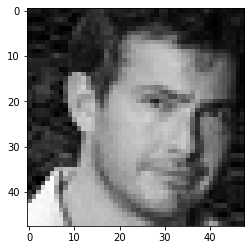

In [ ]:
show_example(*dataset[1])

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
val_size = 3000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(25709, 3000)

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


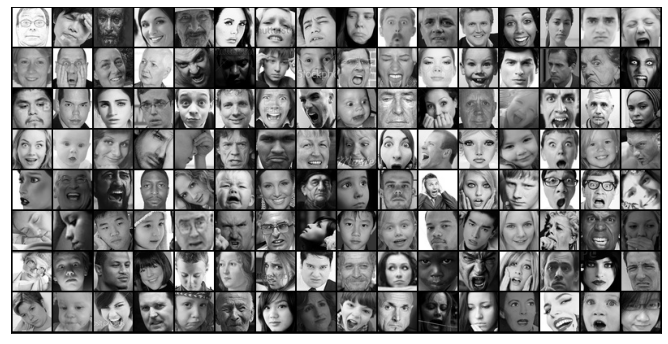

In [ ]:
show_batch(train_dl)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()
        return losses

In [ ]:
class ImageClassificationBase(nn.Module):
     def train(self, dataloader, device="cuda:0"):
        device = torch.device(device)
        for (inputs, labels) in tqdm(dataloader):
            self.optimizer.zero_grad()
            inputs[0] = inputs[0].to(device)
            inputs[1] = inputs[1].to(device)
            inputs[2] = inputs[2].to(device)

            outputs = self(*inputs)

            loss = TripletLoss(*outputs)
            return loss
            
            
     def test(self, dataloader, device="cuda:0"):
        sum_loss = 0.
        
        for (inputs, labels) in tqdm(dataloader):
            inputs[0] = inputs[0].to(device)
            inputs[1] = inputs[1].to(device)
            inputs[2] = inputs[2].to(device)
            
            outputs = self(*inputs)

            loss = TripletLoss(*outputs)
            
            sum_loss += loss.item()*len(inputs)
        
        sum_loss /= len(dataloader.dataset)
        
        print("mean_loss={}".format(sum_loss))
        
        return sum_loss
    
     def validation_step(self, dataloader,device="cuda:0"):

        device = torch.device(device)
        self.model.train()
        for (inputs, labels) in tqdm(dataloader):
            self.optimizer.zero_grad()
            inputs[0] = inputs[0].to(device)
            inputs[1] = inputs[1].to(device)
            inputs[2] = inputs[2].to(device)

            outputs = self(*inputs)

            loss = TripletLoss(*outputs)  # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
     def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
     def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ferCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 24 x 24

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 12 x 12

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 6 x 6

            nn.Flatten(), 
            nn.Linear(256*6*6, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 7))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = ferCnnModel()
model

ferCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=9216, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 3, 48, 48])
out.shape: torch.Size([128, 7])
out[0]: tensor([ 0.0029,  0.0208, -0.0008,  0.0285, -0.0238, -0.0200, -0.0022],
       grad_fn=<SelectBackward0>)


In [ ]:
def evaluate(model, val_loader):
    model.eval(val_loader)
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train(train_loader)
        train_losses = []
        for batch in train_loader:
            loss = model.train(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
model = to_device(ferCnnModel(), device)

In [ ]:
evaluate(model, val_dl)

TypeError: ignored

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/201 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/201 [00:00<?, ?it/s]


AttributeError: ignored